


# **GAT**


In [1]:
!pip install torch-geometric
!pip install torch_sparse
!pip install torch_scatter


# following pytorch geometric example from https://dsgiitr.com/blogs/gat/

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020) # seed for reproducible numbers


class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout = dropout  # drop prob = 0.6
        self.in_features = in_features  #
        self.out_features = out_features  #
        self.alpha = alpha  # LeakyReLU with negative input slope, alpha = 0.2
        self.concat = concat  # conacat = True for all layers except the output layer.

        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# PYG imports

from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
# %matplotlib notebook

import warnings
warnings.filterwarnings("ignore")
name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)


class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid * self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
        # One can skip them if the dataset is sufficiently large.

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 6.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=df5c0453b1635ada31cbf36a852169da22dfa69dba0f87b6520c98ebb3f0174e
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.6 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.15-cp37-cp37m-linux_x86_64.whl size=516860 sha256=64c1384889b6e1b488cca4c96d1a241de423e71f98d1c1522d284a95f94808a3
  Stored in directory: /root/.cache/pip/wheels/15/68/4d/1414be5c2c622bad35364e13213180797717b6d4b8923936dc
Successfully built torch-sparse
Looking in indexes: https://pypi.org/simple, https://us-p

Processing...


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Done!


In [15]:
# Training Loop
import time
start = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GAT().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch % 200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))
end = time.time()
print("Elapsed time: ", end - start)

cpu
tensor(1.9485, grad_fn=<NllLossBackward0>)
tensor(0.7188, grad_fn=<NllLossBackward0>)
tensor(0.6233, grad_fn=<NllLossBackward0>)
tensor(0.6372, grad_fn=<NllLossBackward0>)
tensor(0.4893, grad_fn=<NllLossBackward0>)
Accuracy: 0.8200
Elapsed time:  99.13266205787659


# **Classical algorithms**

In [6]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
from torch_geometric.utils import to_networkx,from_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community


**MST**

In [17]:

import time
start = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GAT().to(device)

data = dataset[0].to(device)
print(data)
G = to_networkx(data, to_undirected=True)
print(G)
G = nx.minimum_spanning_tree(G)
print(G)
newData=from_networkx(G)
print("Old Data:",data)
print("New Data: ",newData)
data.edge_index=newData.edge_index
data=data.to(device)
print(data)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch % 200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()



model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))
end = time.time()
print("Elapsed time: ", end - start)

cpu
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Graph with 2708 nodes and 5278 edges
Graph with 2708 nodes and 2630 edges
Old Data: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
New Data:  Data(edge_index=[2, 5260], num_nodes=2708)
Data(x=[2708, 1433], edge_index=[2, 5260], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor(1.9468, grad_fn=<NllLossBackward0>)
tensor(0.6722, grad_fn=<NllLossBackward0>)
tensor(0.5953, grad_fn=<NllLossBackward0>)
tensor(0.5113, grad_fn=<NllLossBackward0>)
tensor(0.6316, grad_fn=<NllLossBackward0>)
Accuracy: 0.7720
Elapsed time:  76.4991409778595


# **Some fun visualizations (not part of the experiment)**

In [19]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
from torch_geometric.utils import to_networkx,from_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community



In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

print(data)
G = to_networkx(data, to_undirected=True)
print(G)
G = nx.minimum_spanning_tree(G)
print(G)
newData=from_networkx(G)
print("newData: ",newData)
data.edge_index=newData.edge_index
print(data)




Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Graph with 2708 nodes and 5278 edges
Graph with 2708 nodes and 2630 edges
newData:  Data(edge_index=[2, 5260], num_nodes=2708)
Data(x=[2708, 1433], edge_index=[2, 5260], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Number of nodes: 2708
Number of edges: 5260
(2, 5260)
Average node degree: 1.94


,count,mean,std,min,25%,50%,75%,max
0,2708.0,1.94,2.27,1.0,1.0,1.0,2.0,48.0


2708
5260


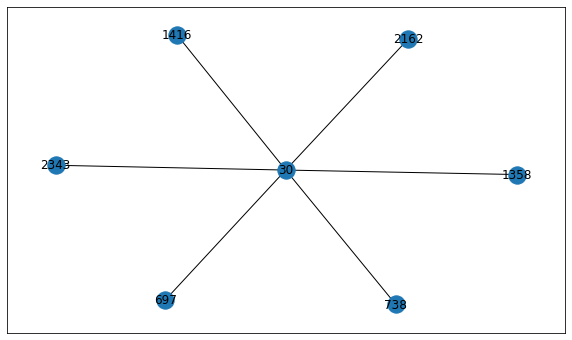

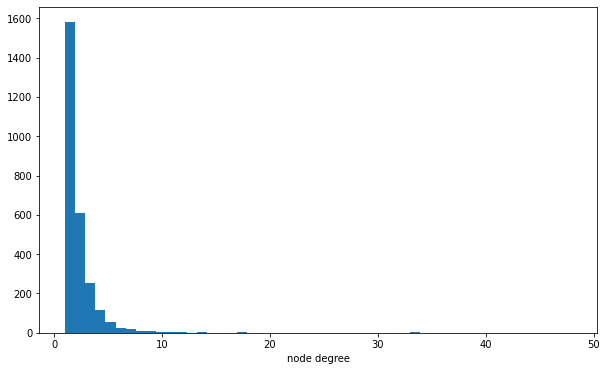

threshold 0.005171776874769117


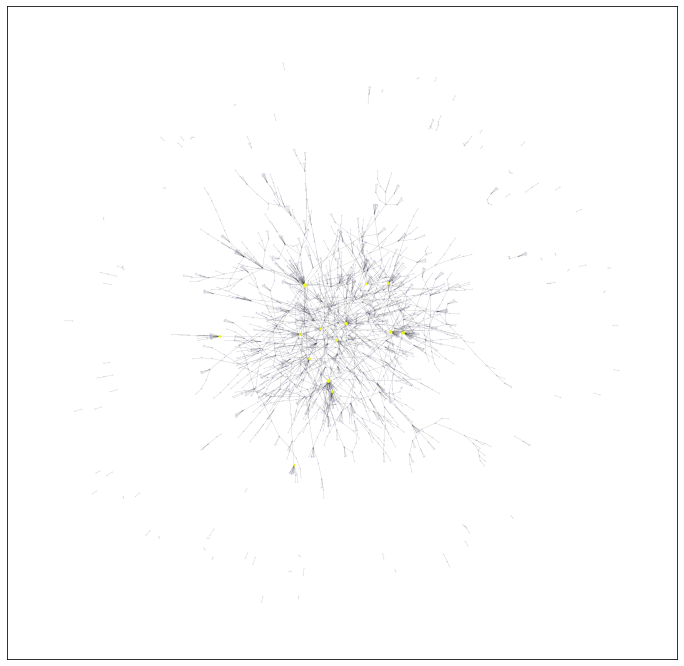

1433
{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


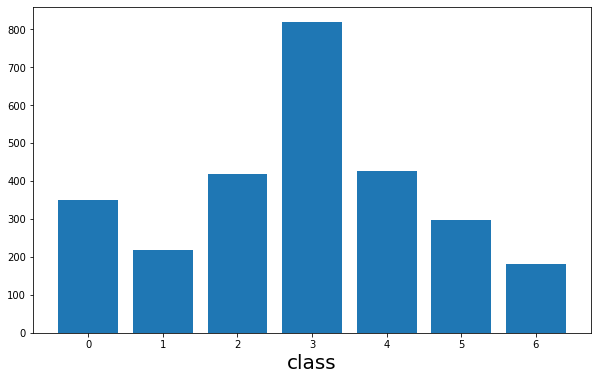

In [23]:
print(f'Number of nodes: {data.num_nodes}')

print(f'Number of edges: {data.num_edges}')

edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=True)
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()
print(len(data.x[0]))
data.x[0][:20]
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()


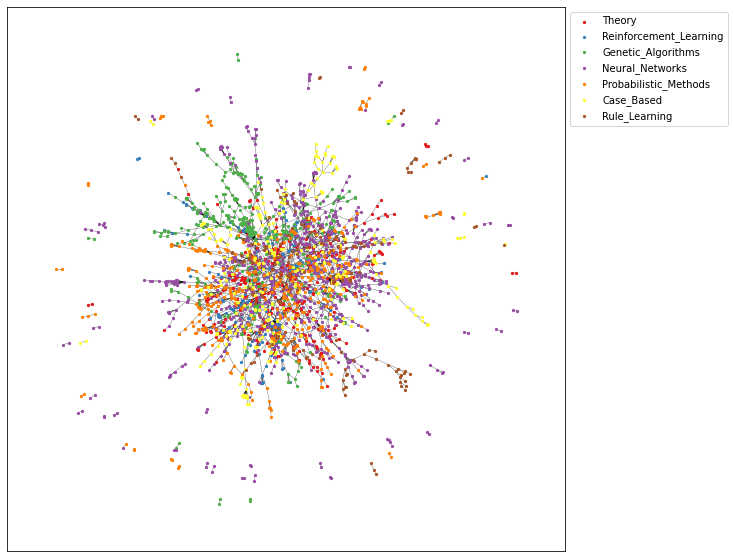

In [22]:

G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')